In [2]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import optuna
import pandas as pd

df = pd.read_csv('../../data/log_data_fe.csv')
df

,ATL_OR_DR,CAMPAIGN_TYPE,CHANNEL,COST,FREE_TRIALS,HOLIDAY_FLAG,LAG_3_HOLIDAY_FLAG,LEAD_3_HOLIDAY_FLAG,SEASON,CHANNEL_ATL_OR_DR,CHANNEL_CAMPAIGN_TYPE,COST_PER_FREE_TRIALS,COST_BY_FREE_TRIALS,LOG_COST,LOG_FREE_TRIALS,LOG_COST_PER_FREE_TRIALS,LOG_COST_BY_FREE_TRIALS
0,DR - Direct Response,Title,paid social,7784.31,86401.15,False,False,False,Summer,paid social_DR - Direct Response,paid social_Title,0.090095,6.725733e+08,8.959994,11.366768,0.086265,20.326622
1,DR - Direct Response,Title,app,2474.31,2956.74,False,False,False,Summer,app_DR - Direct Response,app_Title,0.836837,7.315891e+06,7.814121,7.992181,0.608045,15.805560
2,ATL - Above The Line,Title,paid social,10222.82,12513.08,False,False,False,Summer,paid social_ATL - Above The Line,paid social_Title,0.816971,1.279190e+08,9.232476,9.434610,0.597171,18.666908
3,DR - Direct Response,Title,app,49631.87,17207.04,False,True,False,Winter,app_DR - Direct Response,app_Title,2.884393,8.540176e+08,10.812409,9.753132,1.356967,20.565462
4,ATL - Above The Line,Title,paid social,2081.06,21758.33,False,False,False,Summer,paid social_ATL - Above The Line,paid social_Title,0.095644,4.528039e+07,7.641113,9.987798,0.091343,17.628385
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14103,ATL - Above The Line,Brand,bvod,1478.78,16941.67,False,False,False,Winter,bvod_ATL - Above The Line,bvod_Brand,0.087287,2.505300e+07,7.299649,9.737591,0.083685,17.036504
14104,ATL - Above The Line,Title,ooh,839.25,5727.03,False,False,False,Spring,ooh_ATL - Above The Line,ooh_Title,0.146542,4.806410e+06,6.733699,8.653127,0.136750,15.385461
14105,ATL - Above The Line,Title,bvod,193796.71,34824.51,False,False,False,Winter,bvod_ATL - Above The Line,bvod_Title,5.564952,6.748875e+09,12.174570,10.458105,1.881745,22.632642
14106,ATL - Above The Line,Brand,paid social,84690.65,25140.77,False,False,False,Winter,paid social_ATL - Above The Line,paid social_Brand,3.368658,2.129188e+09,11.346772,10.132286,1.474456,21.479007


In [23]:
df.columns

Index(['ATL_OR_DR', 'CAMPAIGN_TYPE', 'CHANNEL', 'COST', 'FREE_TRIALS',
       'HOLIDAY_FLAG', 'LAG_3_HOLIDAY_FLAG', 'LEAD_3_HOLIDAY_FLAG', 'SEASON',
       'CHANNEL_ATL_OR_DR', 'CHANNEL_CAMPAIGN_TYPE', 'COST_PER_FREE_TRIALS',
       'COST_BY_FREE_TRIALS', 'LOG_COST', 'LOG_FREE_TRIALS',
       'LOG_COST_PER_FREE_TRIALS', 'LOG_COST_BY_FREE_TRIALS'],
      dtype='object')

In [6]:
categorical_columns

['ATL_OR_DR',
 'CAMPAIGN_TYPE',
 'CHANNEL',
 'HOLIDAY_FLAGLAG_3_HOLIDAY_FLAG',
 'LEAD_3_HOLIDAY_FLAG',
 'SEASON',
 'CHANNEL_ATL_OR_DR',
 'CHANNEL_CAMPAIGN_TYPE']

In [7]:
# Split the data into training and testing sets
# X = df.drop(columns=['LOG_FREE_TRIALS', 'REPORT_DATE', 'COST', 'FREE_TRIALS'])
y = df['FREE_TRIALS']
X = df.drop(columns=['LOG_FREE_TRIALS', 'FREE_TRIALS'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify categorical and numerical columns
categorical_columns = ['ATL_OR_DR', 'CAMPAIGN_TYPE', 'CHANNEL', 'HOLIDAY_FLAG',
                       'LAG_3_HOLIDAY_FLAG', 'LEAD_3_HOLIDAY_FLAG', 'SEASON',
                       'CHANNEL_ATL_OR_DR', 'CHANNEL_CAMPAIGN_TYPE']
numerical_columns = ['LOG_COST', 'COST', 'COST_PER_FREE_TRIALS','COST_BY_FREE_TRIALS',
                     'LOG_COST_PER_FREE_TRIALS', 'LOG_COST_BY_FREE_TRIALS']
[]
# Redefine the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ]
)

# Redefine pipelines for XGBoost and Random Forest
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(random_state=42))
])

rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])



# Define hyperparameter grids for XGBoost and Random Forest
xgb_param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__max_depth': [3, 5, 7]
}

rf_param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [10, 20, None],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

# GridSearch for XGBoost
xgb_grid_search = GridSearchCV(xgb_pipeline, xgb_param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)
xgb_grid_search.fit(X_train, y_train)

# GridSearch for Random Forest
rf_grid_search = GridSearchCV(rf_pipeline, rf_param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)
rf_grid_search.fit(X_train, y_train)

# Best parameters and scores for both models
xgb_best_params = xgb_grid_search.best_params_
xgb_best_score = -xgb_grid_search.best_score_

rf_best_params = rf_grid_search.best_params_
rf_best_score = -rf_grid_search.best_score_

xgb_best_params, xgb_best_score, rf_best_params, rf_best_score

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Fitting 3 folds for each of 81 candidates, totalling 243 fits


({'model__learning_rate': 0.2,
  'model__max_depth': 3,
  'model__n_estimators': 200},
 383176697.7490371,
 {'model__max_depth': 20,
  'model__min_samples_leaf': 2,
  'model__min_samples_split': 2,
  'model__n_estimators': 200},
 534074332.4455455)

XGBoost Results:
MSE: 62963224.0892
RMSE: 7934.9369
MAE: 2889.3931
R2 Score: 0.9796

Random Forest Results:
MSE: 30002730.3531
RMSE: 5477.4748
MAE: 945.4124
R2 Score: 0.9903



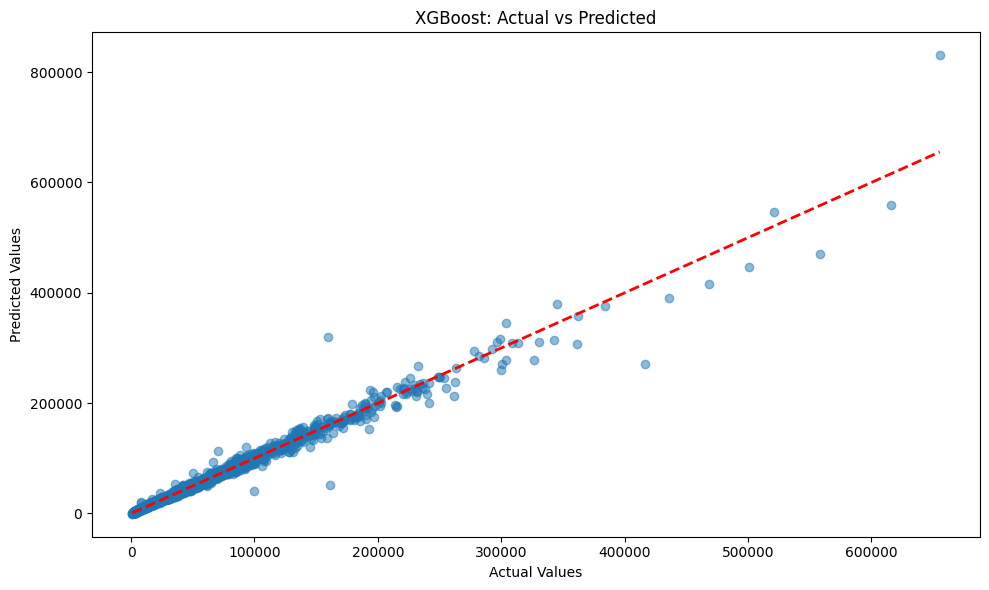

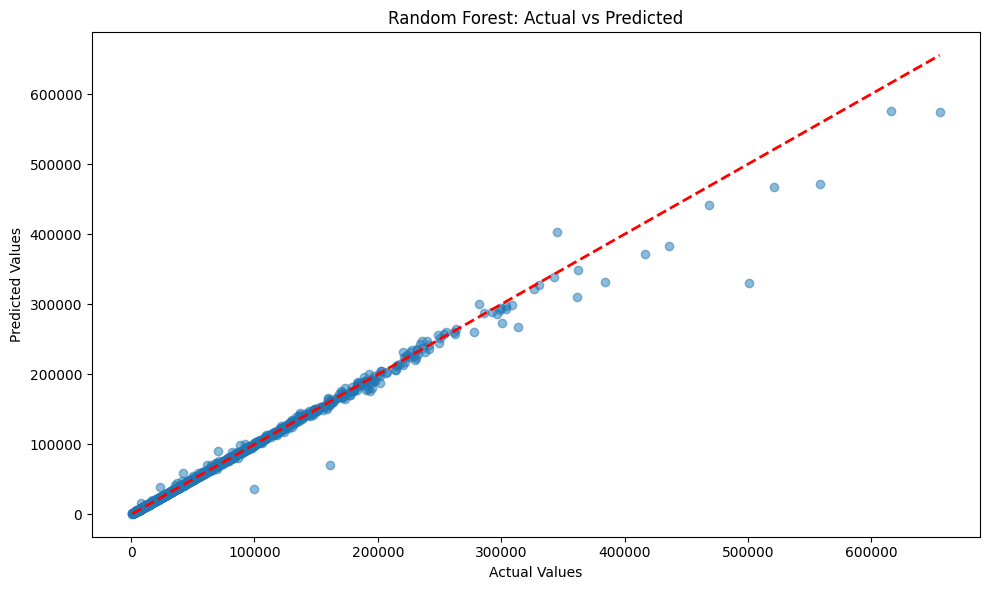

In [8]:
# 1. Get the best models and their scores
xgb_best_model = xgb_grid_search.best_estimator_
rf_best_model = rf_grid_search.best_estimator_

# 2. Get cross-validation results
xgb_cv_results = pd.DataFrame(xgb_grid_search.cv_results_)
rf_cv_results = pd.DataFrame(rf_grid_search.cv_results_)

# 3. Make predictions
xgb_predictions = xgb_best_model.predict(X_test)
rf_predictions = rf_best_model.predict(X_test)

# 4. Evaluate models more thoroughly
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import numpy as np

def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"{model_name} Results:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R2 Score: {r2:.4f}\n")

    return {'mse': mse, 'rmse': rmse, 'mae': mae, 'r2': r2}

# Evaluate both models
xgb_metrics = evaluate_model(y_test, xgb_predictions, "XGBoost")
rf_metrics = evaluate_model(y_test, rf_predictions, "Random Forest")

# 5. Optional: Plot actual vs predicted
import matplotlib.pyplot as plt

def plot_predictions(y_true, y_pred, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_predictions(y_test, xgb_predictions, 'XGBoost: Actual vs Predicted')
plot_predictions(y_test, rf_predictions, 'Random Forest: Actual vs Predicted')